# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [55]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re

# all pyspark stuff
from pyspark.ml import pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LinearSVC, NaiveBayes,RandomForestClassifier, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import CountVectorizer, IDF, StopWordsRemover, StringIndexer, Normalizer, RegexTokenizer, StandardScaler, VectorAssembler, PCA
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import avg, explode, concat, lit, min, max, split, udf, isnull, col, desc
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [56]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("spark_capstone") \
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [57]:
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [58]:
print("The number of rows in the dataframe is {}".format(df.count()))
print("The number of columns in the dataframe is {}".format(len(df.columns)))

The number of rows in the dataframe is 286500
The number of columns in the dataframe is 18


In [59]:
# drop any cells with missing user id or session id
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])
df = df[df.userId != ""]
print(df.count())

278154


In [60]:
df.select('userId').dropDuplicates().sort('userId').show(10)

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
+------+
only showing top 10 rows



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.



### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.



In [61]:
def create_churn(df):
    '''
    Create a column 'Churn' to use as the label for the model. 
    '''
    
    churned_users = df.where(df.page == 'Cancellation Confirmation').select('userId').distinct()
    churned_users_list = list(churned_users.select('userId').toPandas()['userId'])
    df = df.withColumn('Churn', df.userId.isin(churned_users_list))
    
    return df
df = create_churn(df)
df.groupby(df.Churn).agg(countDistinct('userId')).show()

+-----+----------------------+
|Churn|count(DISTINCT userId)|
+-----+----------------------+
| true|                    52|
|false|                   173|
+-----+----------------------+



### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [62]:
pd.DataFrame(df.take(5), columns=df.columns).head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,Churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,False
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,False
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,False


In [63]:
# churn by gender
gender = df.groupby(df.Churn, df.gender).agg(countDistinct('userId')).toPandas()
gender.sort_values(by='gender')

,Churn,gender,count(DISTINCT userId)
0,True,F,20
3,False,F,84
1,False,M,89
2,True,M,32


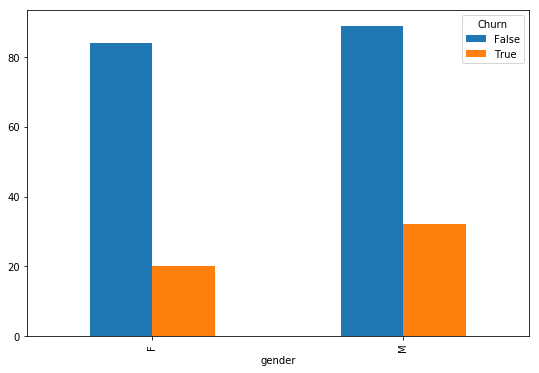

In [64]:
plt.rcParams["figure.figsize"] = (9,6)
gender.pivot(index='gender', columns='Churn', values = 'count(DISTINCT userId)').plot(kind='bar');

In [65]:
# churn by level
level = df.groupby(df.Churn, df.level).agg(countDistinct('userId')).toPandas()
level.sort_values(by='level')

,Churn,level,count(DISTINCT userId)
0,False,free,149
3,True,free,46
1,False,paid,129
2,True,paid,36


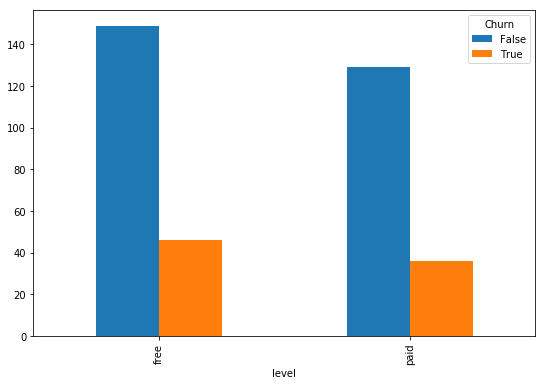

In [66]:
plt.rcParams["figure.figsize"] = (9,6)
level.pivot(index='level', columns='Churn', values = 'count(DISTINCT userId)').plot(kind='bar');

In [67]:
# activity analysis
df.groupby(df.Churn, df.auth).agg(countDistinct('sessionId')).show()
df.groupby(df.Churn).agg(avg('itemInSession')).show()
df.groupby(df.Churn).agg(avg('length')).show()
df.groupby(df.Churn, df.method).agg(countDistinct('sessionId')).show()

+-----+---------+-------------------------+
|Churn|     auth|count(DISTINCT sessionId)|
+-----+---------+-------------------------+
| true|Cancelled|                       52|
|false|Logged In|                     2110|
| true|Logged In|                      468|
+-----+---------+-------------------------+

+-----+------------------+
|Churn|avg(itemInSession)|
+-----+------------------+
| true|109.23299304564907|
|false| 115.9888465000643|
+-----+------------------+

+-----+------------------+
|Churn|       avg(length)|
+-----+------------------+
| true|248.63279564406366|
|false|249.20913538881427|
+-----+------------------+

+-----+------+-------------------------+
|Churn|method|count(DISTINCT sessionId)|
+-----+------+-------------------------+
|false|   PUT|                     2059|
| true|   PUT|                      457|
|false|   GET|                     2009|
| true|   GET|                      450|
+-----+------+-------------------------+



In [68]:
activity = df.groupby(df.page, df.Churn).agg(countDistinct('sessionId')).sort('page', 'Churn').toPandas()
activity

,page,Churn,count(DISTINCT sessionId)
0,About,False,359
1,About,True,49
2,Add Friend,False,1121
3,Add Friend,True,229
4,Add to Playlist,False,1434
5,Add to Playlist,True,299
6,Cancel,True,52
7,Cancellation Confirmation,True,52
8,Downgrade,False,762
9,Downgrade,True,150


In [ ]:
plt.rcParams["figure.figsize"] = (25,15)
sns.barplot(data = activity, x = 'page', y = 'count(DISTINCT sessionId)',hue='Churn')


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [50]:
def cahnge_label_to_int(df):
    df = df.withColumn('label', df['Churn'].cast(IntegerType()))
    return df

def get_pages(df):
    '''
    create variables indicating if a user visited specific pages 
    I made variables for Add Friend and Add to Playlist page visits
    '''
    
    RollAdvert = df.where(df.page == 'Roll Advert').select('userId').distinct()
    RollAdvert_list = list(RollAdvert.select('userId').toPandas()['userId'])
    df = df.withColumn('roll_advert', df.userId.isin(RollAdvert_list))
    
    Downgrade = df.where(df.page == 'Submit Downgrade').select('userId').distinct()
    Downgrade_list = list(Downgrade.select('userId').toPandas()['userId'])
    df = df.withColumn('downgrade', df.userId.isin(Downgrade_list))
    
    Upgrade = df.where(df.page == 'Submit Upgrade').select('userId').distinct()
    Upgrade_list = list(Upgrade.select('userId').toPandas()['userId'])
    df = df.withColumn('upgrade', df.userId.isin(Upgrade_list))
   
    Thumbsdown = df.where(df.page == 'Thumbs Down').select('userId').distinct()
    Thumbsdown_list = list(Thumbsdown.select('userId').toPandas()['userId'])
    df = df.withColumn('thumbsdown', df.userId.isin(Thumbsdown_list))
    
    AddFriend = df.where(df.page == 'Add Friend').select('userId').distinct()
    AddFriend_list = list(AddFriend.select('userId').toPandas()['userId'])
    df = df.withColumn('addfriend', df.userId.isin(AddFriend_list))
    
    AddtoPlaylist = df.where(df.page == 'Add to Playlist').select('userId').distinct()
    AddtoPlaylist_list = list(AddtoPlaylist.select('userId').toPandas()['userId'])
    df = df.withColumn('addtoplaylist', df.userId.isin(AddtoPlaylist_list))
    
    return df

cahnge_label_to_int
get_pages

<function __main__.get_pages(df)>

In [51]:
def get_state_variable(df):
    '''
    form State by using location
    '''
    get_state = udf(lambda x: x.split(',')[1])
    df = df.withColumn('state', get_state(df.location))

    return df

def get_device_variables(df):
    
    get_browser = udf(lambda x: parse(x).browser.family)
    get_os = udf(lambda x: parse(x).os.family)
    get_device = udf(lambda x: parse(x).device.family)
    df = df.withColumn('browser', get_browser(df.userAgent))
    df = df.withColumn('os', get_os(df.userAgent))
    df = df.withColumn('device', get_device(df.userAgent))
    
    return df

get_state_variable
get_device_variables

<function __main__.get_device_variables(df)>

In [52]:
def get_tenure(df):
    '''
    Calculate tenure of the customer
    '''
    max_ts_df = df.groupBy('userId').agg(max('ts').alias('max_ts'))
    df = df.join(max_ts_df, on=['userId'], how = 'left')
    df = df.withColumn('tenure', ((df.max_ts-df.registration)/86400000).cast(IntegerType()))    
    
    return df


def get_user_stats(df):
    '''
    get user level stats
    '''
    w = Window.partitionBy(df.userId)
    df = df.withColumn('num_songs', approx_count_distinct(df.song).over(w))
    df = df.withColumn('num_artists', approx_count_distinct(df.artist).over(w))
    df = df.withColumn('avg_length', avg(df.length).over(w))
    
    return df    

get_tenure
get_user_stats

<function __main__.get_user_stats(df)>

In [53]:
columns_to_drop = ['userId', 'artist', 'auth', 'firstName', 'itemInSession', 'lastName', 'length', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status',
                       'ts', 'userAgent', 'max_ts', 'Churn']
    
df_data = df.drop(*columns_to_drop) 

In [54]:
pd.DataFrame(df_data.orderBy(rand()).take(5), columns=df_model.columns)

NameError: name 'df_model' is not defined

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.